In [1]:
# Imports for evalution and visualization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
import os
from datetime import datetime
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score
import tensorflow as tf
from tensorflow import keras

In [2]:
# Filter warnings out

warnings.filterwarnings('ignore')

In [3]:
# Visualization Setup

plt.style.use('default')
sns.set_palette("husl")

In [4]:

# Loading Models and Configuration

MODELS_DIR = '../models'
DATA_DIR = '../data/processed'

def load_latest_models_and_data():
    """
    Loads the models and associated data using the manifest file
    """
    try:
        # Load the latest manifest
        manifest_path = os.path.join(MODELS_DIR, 'manifest_latest.pkl')
        if not os.path.exists(manifest_path):
            # If no latest manifest, find the most recent one
            manifest_files = [f for f in os.listdir(MODELS_DIR) if f.startswith('manifest_') and f.endswith('.pkl') and 'latest' not in f]
            
            if not manifest_files:
                raise FileNotFoundError("No manifest files found")
            # Get the most recent manifest by timestamp
            manifest_files.sort(reverse=True)
            manifest_path = os.path.join(MODELS_DIR, manifest_files[0])
        
        manifest = joblib.load(manifest_path)
        timestamp = manifest['timestamp']
        print(f"Loading models from timestamp: {timestamp}")
        
        # Load all trained models
        models = {}
        
        # Logistic Regression Model
        lr_path = os.path.join(MODELS_DIR, manifest['model_files']['logistic_regression'])
        models['logistic_regression'] = joblib.load(lr_path)
        print("- Logistic Regression model loaded")
        
        # Random Forest Model
        rf_path = os.path.join(MODELS_DIR, manifest['model_files']['random_forest'])
        models['random_forest'] = joblib.load(rf_path)
        print("- Random Forest model loaded")
        
        # XGBoost Model
        xgb_path = os.path.join(MODELS_DIR, manifest['model_files']['xgboost'])
        models['xgboost'] = joblib.load(xgb_path)
        print("- XGBoost model loaded")
        
        # Neural Network Model
        nn_path = os.path.join(MODELS_DIR, manifest['model_files']['neural_network'])
        models['neural_network'] = keras.models.load_model(nn_path)
        print("- Neural Network model loaded")
        
        # Loads all predictions
        pred_path = os.path.join(MODELS_DIR, manifest['data_files']['predictions'])
        predictions = joblib.load(pred_path)
        print("- All predictions loaded")
        
        # Loads performance metrics
        metrics_path = os.path.join(MODELS_DIR, manifest['data_files']['metrics'])
        performance_metrics = joblib.load(metrics_path)
        print("- Performance metrics loaded")
        
        # Loads feature importance data
        importance_path = os.path.join(MODELS_DIR, manifest['data_files']['feature_importance'])
        feature_importance = joblib.load(importance_path)
        print("- Feature importance data loaded")
        
        # Loads hyperparameter results
        hyperparam_path = os.path.join(MODELS_DIR, manifest['data_files']['hyperparameters'])
        hyperparameter_results = joblib.load(hyperparam_path)
        print("- Hyperparameter results loaded")
        
        # Loads neural network training history
        nn_history_path = os.path.join(MODELS_DIR, manifest['data_files']['nn_history'])
        nn_history = joblib.load(nn_history_path)
        print("- Neural network training history loaded")
        
        # Loads data info
        data_info_path = os.path.join(MODELS_DIR, manifest['data_files']['data_info'])
        data_info = joblib.load(data_info_path)
        print("- Data info loaded")
        
        return {
            'models': models,
            'predictions': predictions,
            'performance_metrics': performance_metrics,
            'feature_importance': feature_importance,
            'hyperparameter_results': hyperparameter_results,
            'nn_history': nn_history,
            'data_info': data_info,
            'manifest': manifest,
            'timestamp': timestamp
        }
        
    except Exception as e:
        print(f"Error loading models: {str(e)}")
        return None

def load_original_data():
    """
    Loads the original processed datasets
    """
    try:
        # Loads training data
        X_train = pd.read_csv(os.path.join(DATA_DIR, 'X_train_final.csv'))
        y_train = pd.read_csv(os.path.join(DATA_DIR, 'y_train_final.csv')).squeeze()
        
        # Loads validation data
        X_val = pd.read_csv(os.path.join(DATA_DIR, 'X_validation_final.csv'))
        y_val = pd.read_csv(os.path.join(DATA_DIR, 'y_validation_final.csv')).squeeze()
        
        # Loads test data
        X_test = pd.read_csv(os.path.join(DATA_DIR, 'X_test_final.csv'))
        y_test = pd.read_csv(os.path.join(DATA_DIR, 'y_test_final.csv')).squeeze()
        
        # Loads preprocessing objects
        selected_features = joblib.load(os.path.join(DATA_DIR, 'selected_features.pkl'))
        class_weights = joblib.load(os.path.join(DATA_DIR, 'class_weights.pkl'))
        
        # Loads the scaler (latest one if it exists)
        scaler_files = [f for f in os.listdir(DATA_DIR) if f.endswith('_scaler.pkl')]
        if scaler_files:
            scaler_path = os.path.join(DATA_DIR, scaler_files[-1])  # Get the most recent
            scaler = joblib.load(scaler_path)
        else:
            print("Warning: No scaler found")
            scaler = None
            
        print("Original data loaded successfully")
        print(f"- Training: {X_train.shape}")
        print(f"- Validation: {X_val.shape}")
        print(f"- Test: {X_test.shape}")
        print(f"- Features: {len(selected_features)}")
        print(f"- Features ({len(selected_features)}):")
        for i, feature in enumerate(selected_features, 1):
            print(f"  {i}. {feature}")
        
        return {
            'X_train': X_train,
            'y_train': y_train,
            'X_val': X_val,
            'y_val': y_val,
            'X_test': X_test,
            'y_test': y_test,
            'selected_features': selected_features,
            'class_weights': class_weights,
            'scaler': scaler
        }
        
    except Exception as e:
        print(f"Error loading original data: {str(e)}")
        return None

# Loads everything
loaded_data = load_latest_models_and_data()
original_data = load_original_data()

# Makes key objects easily accessible
if loaded_data and original_data:
    # Extracts key objects for easy access
    models = loaded_data['models']
    predictions = loaded_data['predictions']
    performance_metrics = loaded_data['performance_metrics']
    feature_importance = loaded_data['feature_importance']
    
    # Extracts individual model metrics from the performance_metrics dictionary
    # Logistic Regression metrics
    if 'logistic_regression' in performance_metrics:
        lr_metrics = performance_metrics['logistic_regression']
        train_metrics = lr_metrics.get('train', {})
        val_metrics = lr_metrics.get('validation', {})
        test_metrics = lr_metrics.get('test', {})
    
    # Random Forest metrics  
    if 'random_forest' in performance_metrics:
        rf_metrics = performance_metrics['random_forest']
        train_metrics_rf = rf_metrics.get('train', {})
        val_metrics_rf = rf_metrics.get('validation', {})
        test_metrics_rf = rf_metrics.get('test', {})
    
    # XGBoost metrics
    if 'xgboost' in performance_metrics:
        xgb_metrics = performance_metrics['xgboost']
        xgb_train_metrics = xgb_metrics.get('train', {})
        xgb_val_metrics = xgb_metrics.get('validation', {})
        xgb_test_metrics = xgb_metrics.get('test', {})
    
    # Neural Network metrics
    if 'neural_network' in performance_metrics:
        nn_metrics = performance_metrics['neural_network']
        nn_train_metrics = nn_metrics.get('train', {})
        nn_val_metrics = nn_metrics.get('validation', {})
        nn_test_metrics = nn_metrics.get('test', {})
    
    # Extracts predictions for each model
    if 'logistic_regression' in predictions:
        y_train_prob = predictions['logistic_regression'].get('train_prob', [])
        y_val_prob = predictions['logistic_regression'].get('val_prob', [])
        y_test_prob = predictions['logistic_regression'].get('test_prob', [])
    
    if 'random_forest' in predictions:
        y_val_prob_rf = predictions['random_forest'].get('val_prob', [])
        
    if 'xgboost' in predictions:
        y_val_prob_xgb = predictions['xgboost'].get('val_prob', [])
        
    if 'neural_network' in predictions:
        y_val_prob_nn = predictions['neural_network'].get('val_prob', [])
    
    # Extracts feature importance for each model
    if 'logistic_regression' in feature_importance:
        feature_importance_lr = feature_importance['logistic_regression']
    
    if 'random_forest' in feature_importance:
        feature_importance_rf = feature_importance['random_forest']
        
    if 'xgboost' in feature_importance:
        feature_importance_xgb = feature_importance['xgboost']
    
    # Original data
    X_train, y_train = original_data['X_train'], original_data['y_train']
    X_val, y_val = original_data['X_val'], original_data['y_val']
    X_test, y_test = original_data['X_test'], original_data['y_test']
    selected_features = original_data['selected_features']
    class_weights = original_data['class_weights']
    scaler = original_data['scaler']
    
    print("\nAll data structures properly extracted and ready for analysis")
    print(f"Available models: {list(models.keys())}")
    print(f"Available performance metrics: {list(performance_metrics.keys())}")
    
else:
    print("Failed to load models or data")

Loading models from timestamp: 20250820_161828
- Logistic Regression model loaded
- Random Forest model loaded
- XGBoost model loaded
- Neural Network model loaded
- All predictions loaded
- Performance metrics loaded
- Feature importance data loaded
- Hyperparameter results loaded
- Neural network training history loaded
- Data info loaded
Original data loaded successfully
- Training: (6975, 34)
- Validation: (2567, 34)
- Test: (589, 34)
- Features: 34
- Features (34):
  1. total_actions
  2. made_shots
  3. missed_shots
  4. free_throws
  5. rebounds
  6. fouls
  7. turnovers
  8. total_shot_attempts
  9. shooting_efficiency
  10. total_actions_30d
  11. shooting_load_30d
  12. defensive_load_30d
  13. substitution_rate_30d
  14. contact_usage_rate
  15. substitution_frequency
  16. shots_vs_season_avg
  17. rebounds_vs_season_avg
  18. performance_drop_7vs30
  19. current_vs_14day_avg
  20. shooting_eff_decline
  21. is_low_performance
  22. consecutive_low_games
  23. actions_trend

# Model Performance Heatmap

### Overview
The create_performance_heatmap() function generates a visualization comparing four machine learning models (Logistic Regression, Random Forest, XGBoost, Neural Network) across six performance metrics on train/validation/test datasets. The heatmap effectively visualizes these performance patterns but highlights fundamental issues in the modeling pipeline that require immediate attention.

### Key Findings

**Model Performance Ranking:**
1. **Random Forest** - Shows realtively strongest overall performance with high training metrics (0.985 accuracy, 0.996 ROC AUC)
2. **XGBoost** - Performance with 0.822 training accuracy and 0.884 ROC AUC
3. **Logistic Regression** - Better training than test results
4. **Neural Network** - Weakest performer across all metrics

**Critical Issues**
- **Overfitting**: Random Forest shows 0.996 train validation ROC AUC gap, indicating poor generalization
- **Validation Data Problems**: All validation metrics show zero or near zero values, suggesting potential data leakage or preprocessing errors
- **Test Performance Drop**: Performance degradation from training to test sets across all models

**Improvement Recommendations:**
1. Investigate validation set construction and data preprocessing pipeline
2. Implement stronger regularization techniques for Random Forest
3. Consider ensemble methods combining XGBoost and regularized models
4. Review feature engineering to address the train/test performance gap

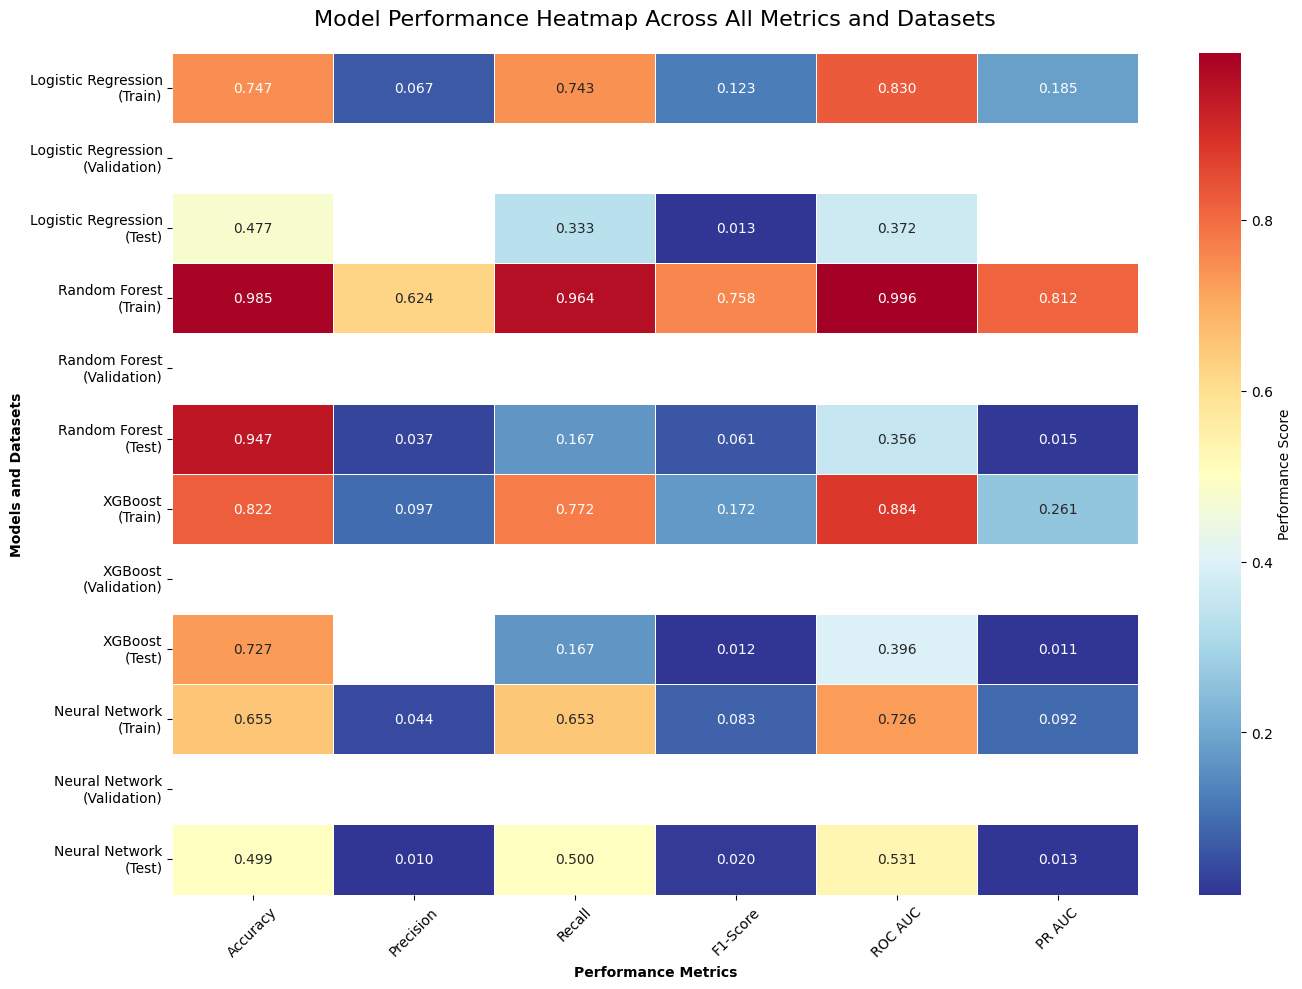

Key Performance Insights:
Best Validation ROC AUC: 0.000
Best Validation PR AUC: 0.000
Highest Overfitting (Train-Val ROC gap): 0.996


In [5]:
def create_performance_heatmap():
    """
    Creates a heatmap showing all performance metrics across models and datasets
    """
    # Checsk if all required metrics are available
    required_metrics = [
        'train_metrics', 'val_metrics', 'test_metrics',
        'train_metrics_rf', 'val_metrics_rf', 'test_metrics_rf', 
        'xgb_train_metrics', 'xgb_val_metrics', 'xgb_test_metrics',
        'nn_train_metrics', 'nn_val_metrics', 'nn_test_metrics'
    ]
    
    # Checks if metrics exist in globals
    missing_metrics = [metric for metric in required_metrics if metric not in globals()]
    if missing_metrics:
        print(f"Missing metrics: {missing_metrics}")
        print("Please ensure all performance metrics are properly loaded.")
        return
    
    # Organizes performance data
    try:
        performance_data = {
            'Logistic Regression': {
                'Train': [train_metrics.get('accuracy', 0), train_metrics.get('precision', 0), train_metrics.get('recall', 0),
                         train_metrics.get('f1', 0), train_metrics.get('roc_auc', 0), train_metrics.get('pr_auc', 0)],
                'Validation': [val_metrics.get('accuracy', 0), val_metrics.get('precision', 0), val_metrics.get('recall', 0),
                              val_metrics.get('f1', 0), val_metrics.get('roc_auc', 0), val_metrics.get('pr_auc', 0)],
                'Test': [test_metrics.get('accuracy', 0), test_metrics.get('precision', 0), test_metrics.get('recall', 0),
                        test_metrics.get('f1', 0), test_metrics.get('roc_auc', 0), test_metrics.get('pr_auc', 0)]
            },
            'Random Forest': {
                'Train': [train_metrics_rf.get('accuracy', 0), train_metrics_rf.get('precision', 0), train_metrics_rf.get('recall', 0),
                         train_metrics_rf.get('f1', 0), train_metrics_rf.get('roc_auc', 0), train_metrics_rf.get('pr_auc', 0)],
                'Validation': [val_metrics_rf.get('accuracy', 0), val_metrics_rf.get('precision', 0), val_metrics_rf.get('recall', 0),
                              val_metrics_rf.get('f1', 0), val_metrics_rf.get('roc_auc', 0), val_metrics_rf.get('pr_auc', 0)],
                'Test': [test_metrics_rf.get('accuracy', 0), test_metrics_rf.get('precision', 0), test_metrics_rf.get('recall', 0),
                        test_metrics_rf.get('f1', 0), test_metrics_rf.get('roc_auc', 0), test_metrics_rf.get('pr_auc', 0)]
            },
            'XGBoost': {
                'Train': [xgb_train_metrics.get('accuracy', 0), xgb_train_metrics.get('precision', 0), xgb_train_metrics.get('recall', 0),
                         xgb_train_metrics.get('f1', 0), xgb_train_metrics.get('roc_auc', 0), xgb_train_metrics.get('pr_auc', 0)],
                'Validation': [xgb_val_metrics.get('accuracy', 0), xgb_val_metrics.get('precision', 0), xgb_val_metrics.get('recall', 0),
                              xgb_val_metrics.get('f1', 0), xgb_val_metrics.get('roc_auc', 0), xgb_val_metrics.get('pr_auc', 0)],
                'Test': [xgb_test_metrics.get('accuracy', 0), xgb_test_metrics.get('precision', 0), xgb_test_metrics.get('recall', 0),
                        xgb_test_metrics.get('f1', 0), xgb_test_metrics.get('roc_auc', 0), xgb_test_metrics.get('pr_auc', 0)]
            },
            'Neural Network': {
                'Train': [nn_train_metrics.get('accuracy', 0), nn_train_metrics.get('precision', 0), nn_train_metrics.get('recall', 0),
                         nn_train_metrics.get('f1', 0), nn_train_metrics.get('roc_auc', 0), nn_train_metrics.get('pr_auc', 0)],
                'Validation': [nn_val_metrics.get('accuracy', 0), nn_val_metrics.get('precision', 0), nn_val_metrics.get('recall', 0),
                              nn_val_metrics.get('f1', 0), nn_val_metrics.get('roc_auc', 0), nn_val_metrics.get('pr_auc', 0)],
                'Test': [nn_test_metrics.get('accuracy', 0), nn_test_metrics.get('precision', 0), nn_test_metrics.get('recall', 0),
                        nn_test_metrics.get('f1', 0), nn_test_metrics.get('roc_auc', 0), nn_test_metrics.get('pr_auc', 0)]
            }
        }
        
        # Creates DataFrame for heatmap
        metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC', 'PR AUC']
        heatmap_data = []
        row_labels = []
        
        for model, datasets in performance_data.items():
            for dataset, values in datasets.items():
                heatmap_data.append(values)
                row_labels.append(f"{model}\n({dataset})")
        
        heatmap_df = pd.DataFrame(heatmap_data, columns=metrics_names, index=row_labels)
        
        # Create heatmap
        plt.figure(figsize=(14, 10))
        mask = heatmap_df < 0.01  # Mask very low values for better visualization
        
        sns.heatmap(heatmap_df, annot=True, cmap='RdYlBu_r', fmt='.3f',
                    linewidths=0.5, cbar_kws={'label': 'Performance Score'},
                    mask=mask, square=False)
        
        plt.title('Model Performance Heatmap Across All Metrics and Datasets', fontsize=16, pad=20)
        plt.xlabel('Performance Metrics', fontweight='bold')
        plt.ylabel('Models and Datasets', fontweight='bold')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
        # Prints key insights
        print("Key Performance Insights:")
        val_rows = heatmap_df.index.str.contains('Validation')
        if val_rows.any():
            print(f"Best Validation ROC AUC: {heatmap_df.loc[val_rows, 'ROC AUC'].max():.3f}")
            print(f"Best Validation PR AUC: {heatmap_df.loc[val_rows, 'PR AUC'].max():.3f}")
            
        train_rows = heatmap_df.index.str.contains('Train')
        if train_rows.any() and val_rows.any():
            train_roc = heatmap_df.loc[train_rows, 'ROC AUC']
            val_roc = heatmap_df.loc[val_rows, 'ROC AUC']
            if len(train_roc) == len(val_roc):
                overfitting_gaps = train_roc.values - val_roc.values
                print(f"Highest Overfitting (Train-Val ROC gap): {overfitting_gaps.max():.3f}")
                
    except Exception as e:
        print(f"Error creating heatmap: {str(e)}")
        print("Check that all performance metrics are properly loaded")

create_performance_heatmap()

# ROC and Precision Recall Curves Analysis

### Overview
The  plot_roc_pr_curves() function generates side by side ROC and Precision-Recall curves for model comparison on the validation set. These curves provide complementary perspectives on classifier performance, with ROC curves showing overall discrimination ability and PR curves highlighting performance on the minority class.

### Key Findings

**ROC Curve Performance:**
1. **XGBoost** - Best discriminative performance (AUC = 0.690), showing better ability to distinguish between classes
2. **Random Forest** - Close second (AUC = 0.647) with similar curve shape to XGBoost
3. **Logistic Regression** - Moderate performance (AUC = 0.645), nearly matching Random Forest
4. **Neural Network** - Strongest performance (AUC = 0.590), only marginally better than random guessing

**Precision Recall Performance:**
- **Random Forest** - Highest average precision (AP = 0.121), indicating better performance on positive class identification
- **Logistic Regression** - Second best (AP = 0.098) with consistent precision across recall levels
- **XGBoost** - Third place (AP = 0.083) despite having the best ROC performance
- **Neural Network** - Poorest performance (AP = 0.045), struggling with minority class detection

**Critical Observations:**
- **Class Imbalance Impact**: Low baseline precision (0.030) indicates severe class imbalance in the dataset
- **Model Divergence**: Different rankings between ROC and PR metrics suggest varying strengths in handling imbalanced data
- **Validation Consistency**: Results align with previous heatmap findings showing modest validation performance across all models

**Improvemnet Recomendations:**
1. For balanced datasets, prioritize XGBoost based on ROC performance
2. For imbalanced scenarios, consider Random Forest given superior PR curve performance
3. All models show room for improvement through class balancing techniques and threshold optimization
4. Neural Network requires architectural refinement or additional regularization

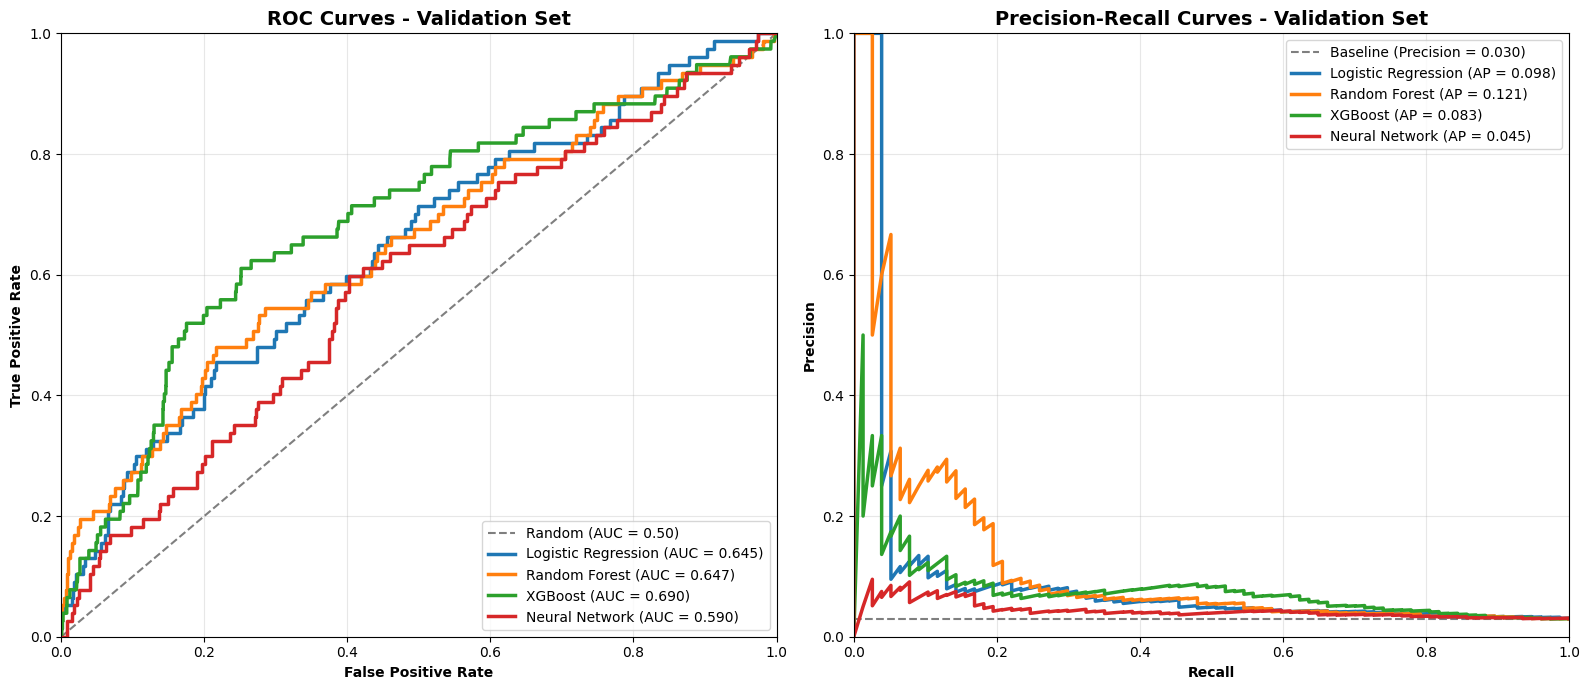

In [6]:
# ROC and PR Curves Comparison
def plot_roc_pr_curves():
    """
    Plots ROC and Precision-Recall curves for all models on validation set
    """
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Model data
    models_data = {
        'Logistic Regression': {'prob': y_val_prob, 'color': '#1f77b4'},
        'Random Forest': {'prob': y_val_prob_rf, 'color': '#ff7f0e'},
        'XGBoost': {'prob': y_val_prob_xgb, 'color': '#2ca02c'},
        'Neural Network': {'prob': y_val_prob_nn, 'color': '#d62728'}
    }
    
    # ROC Curves
    ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random (AUC = 0.50)')
    
    for model_name, data in models_data.items():
        fpr, tpr, _ = roc_curve(y_val, data['prob'])
        roc_auc = roc_auc_score(y_val, data['prob'])
        ax1.plot(fpr, tpr, color=data['color'], linewidth=2.5, 
                label=f'{model_name} (AUC = {roc_auc:.3f})')
    
    ax1.set_xlabel('False Positive Rate', fontweight='bold')
    ax1.set_ylabel('True Positive Rate', fontweight='bold')
    ax1.set_title('ROC Curves - Validation Set', fontsize=14, fontweight='bold')
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    
    # PR Curves
    baseline = y_val.mean()
    ax2.axhline(y=baseline, color='k', linestyle='--', alpha=0.5, 
                label=f'Baseline (Precision = {baseline:.3f})')
    
    for model_name, data in models_data.items():
        precision, recall, _ = precision_recall_curve(y_val, data['prob'])
        pr_auc = average_precision_score(y_val, data['prob'])
        ax2.plot(recall, precision, color=data['color'], linewidth=2.5,
                label=f'{model_name} (AP = {pr_auc:.3f})')
    
    ax2.set_xlabel('Recall', fontweight='bold')
    ax2.set_ylabel('Precision', fontweight='bold')
    ax2.set_title('Precision-Recall Curves - Validation Set', fontsize=14, fontweight='bold')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])
    
    plt.tight_layout()
    plt.show()

plot_roc_pr_curves()

# Feature Importance Comparison Analysis

### Overview

The compare_feature_importance() function provides a comprehensive view of feature importance across three models, revealing both model specific preferences and consensus features. The analysis includes directional coefficients for Logistic Regression and importance scores for tree based models, culminating in a consensus ranking.

### Key Findings

**Logistic Regression:**
- **Strongest Positive Predictors**: fatigue_score (1.836), total_actions (1.417), shooting_load_30d (1.175)
- **Strongest Negative Predictors**: is_back_to_back (-1.467), cumulative_actions_30d (-1.467), rebounds (-0.978)
- **Interpretation**: Higher fatigue and recent activity increase injury risk, while back to back games show protective association (likely due to load management)

**Random Forest:**
- **Top Predictors**: fatigue_score (0.134), game_day_of_week (0.066), current_vs_14day_avg (0.049)
- **Focus**: Emphasizes fatigue, scheduling patterns, and recent performance deviations
- **Pattern**: More balanced importance distribution compared to other models

**XGBoost:**
- **Top Predictors**: fatigue_score (0.085), rebounds_vs_season_avg (0.061), current_vs_14day_avg (0.053)
- **Strength**: Captures performance anomalies and statistical deviations from baseline metrics
- **Advantage**: Better at identifying subtle performance changes that precede injuries

**Critical Findings:**
- **Universal Predictor**: fatigue_score emerges as the single most important feature across all models
- **Model Divergence**: Only 1 out of 20 unique features shows complete consensus, indicating different models capture distinct injury risk patterns
- **Feature Diversity**: 20 total unique important features suggests complex, multifaceted injury risk factors

### Improvement Recommendations

**Strategic Insights:**
- **Fatigue Monitoring**: Universal importance of fatigue_score validates fatigue as primary injury risk factor
- **Model Ensemble Value**: Different feature preferences suggest ensemble approaches could capture comprehensive risk patterns
- **Load Management**: Conflicting signals around back-to-back games and cumulative load indicate complex relationship requiring careful interpretation
- **Performance Monitoring**: Deviation based features (current_vs_14day_avg, rebounds_vs_season_avg) show promise for early warning systems
- Prioritize fatigue tracking systems for immediate impact
- Combine model predictions to leverage diverse feature insights
- Investigate the counterintuitive back-to-back game relationship
- Develop performance deviation alerts based on season averages

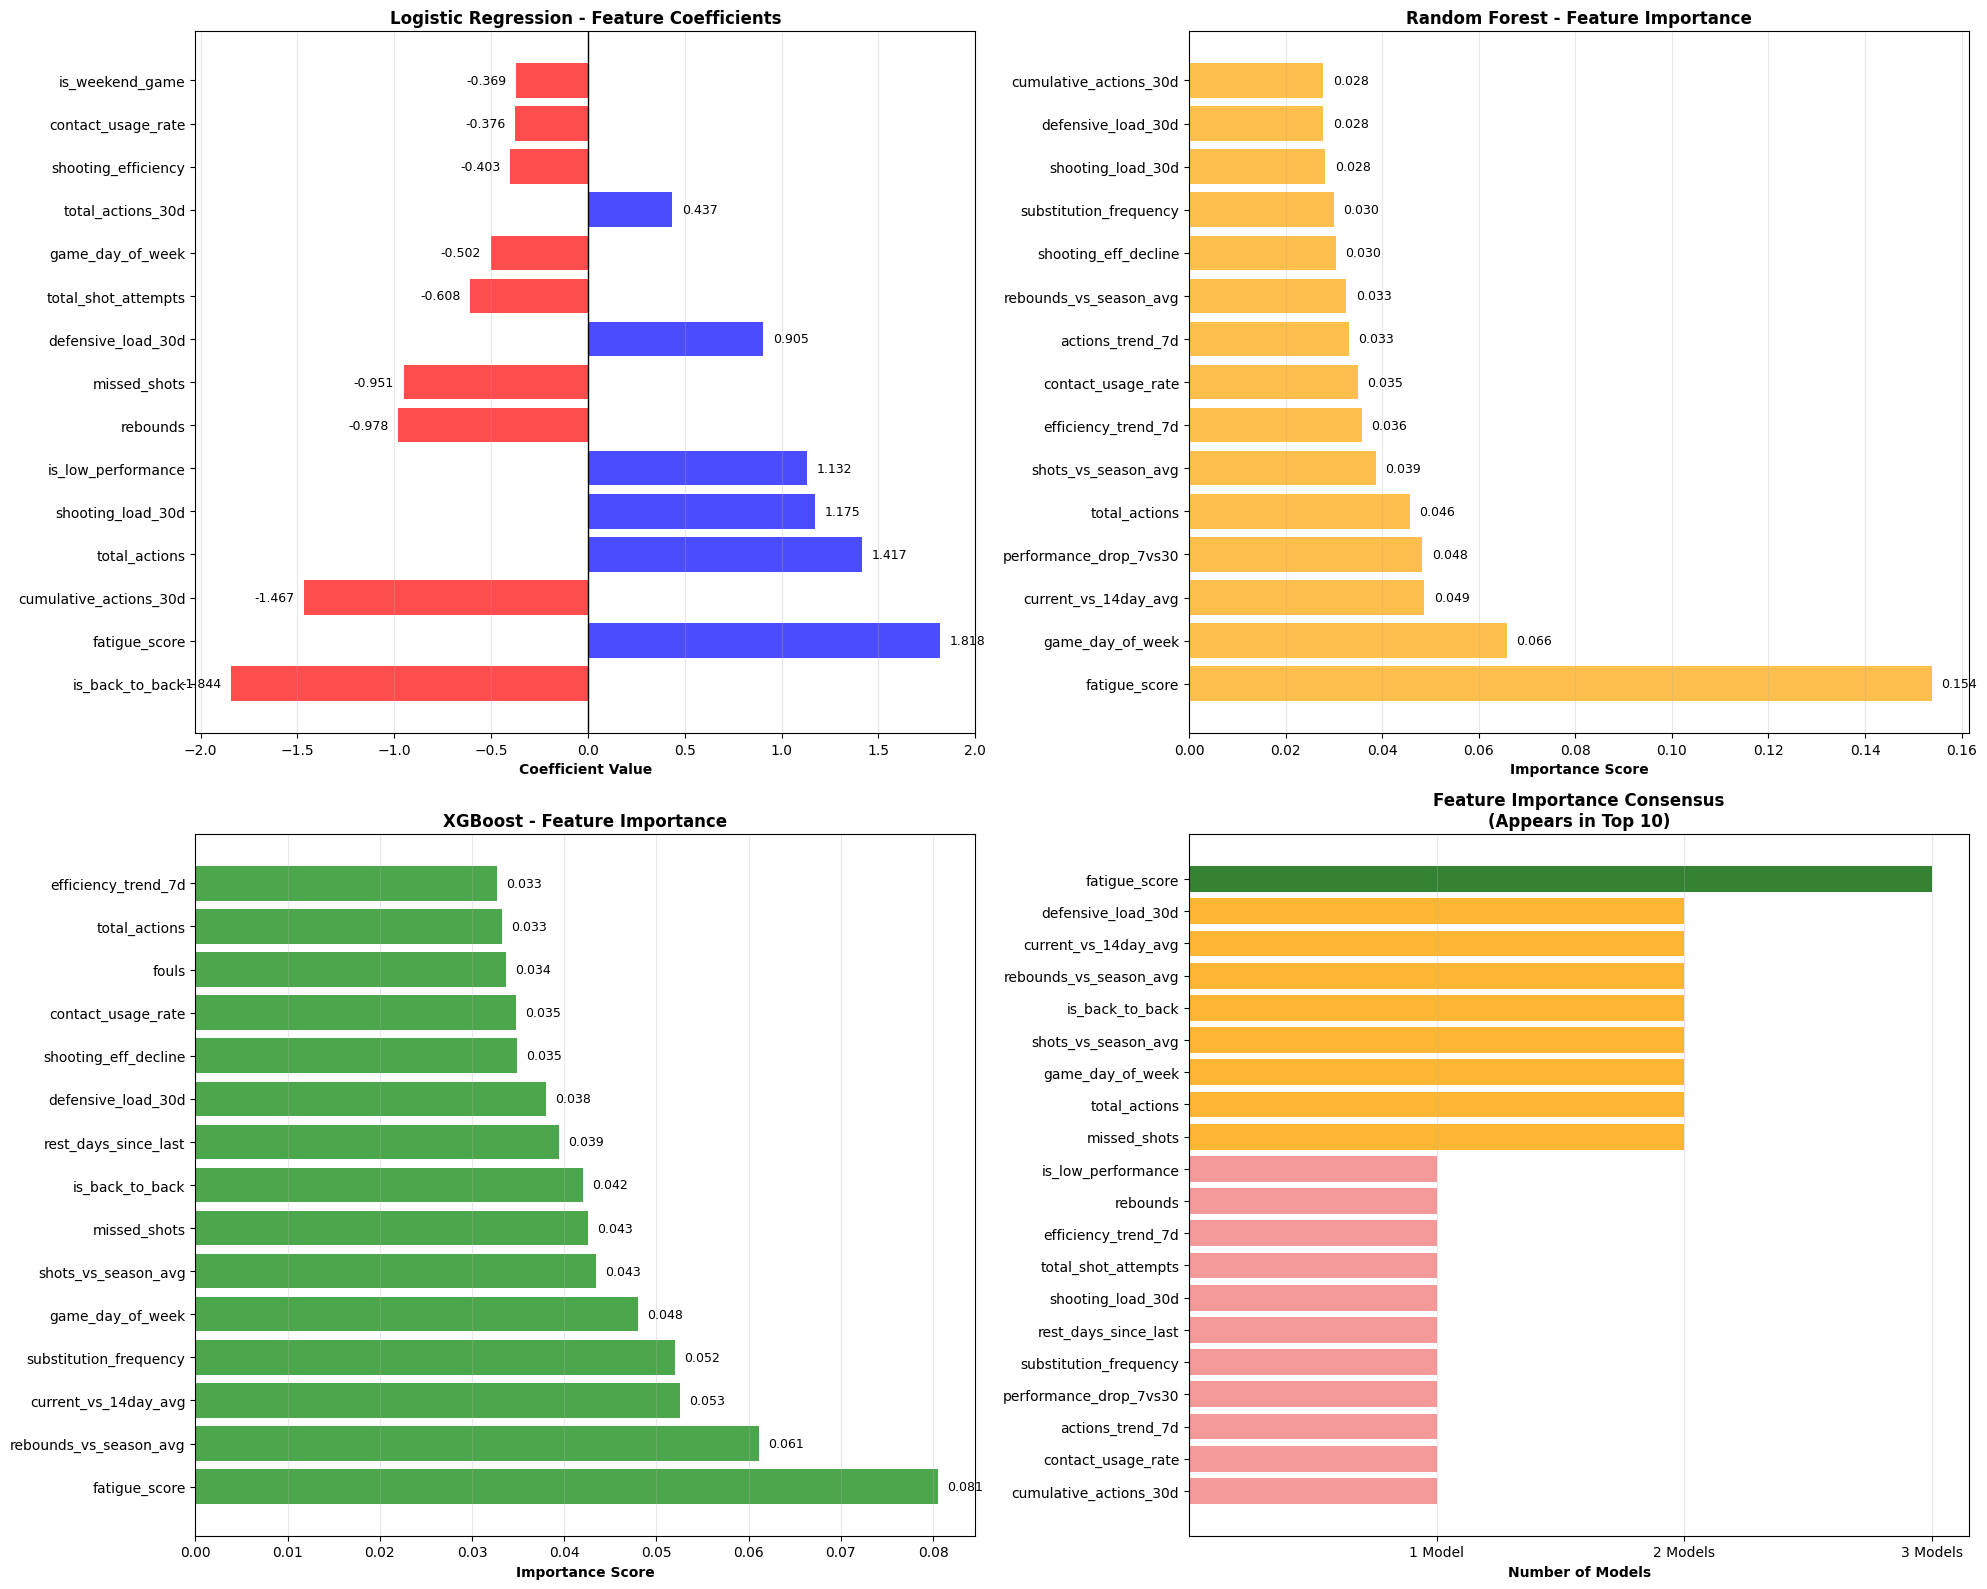

Feature Importance Insights:
Features important in all 3 models: 1
Consensus features: fatigue_score
Total unique important features: 20


In [7]:
# Feature Importance Comparison 
def compare_feature_importance():
    """
    Compares feature importance across different models
    """
    # Accesses feature importance DataFrames directly
    top_features_lr = feature_importance['logistic_regression'].head(15).copy()
    top_features_lr['model'] = 'Logistic Regression'
    top_features_lr['importance'] = top_features_lr['abs_coefficient']
    
    top_features_rf = feature_importance['random_forest'].head(15).copy()
    top_features_rf['model'] = 'Random Forest'
    
    top_features_xgb = feature_importance['xgboost'].head(15).copy()
    top_features_xgb['model'] = 'XGBoost'

    # Creates subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))

    # Logistic Regression coefficients (showing direction)
    ax1 = axes[0, 0]
    lr_plot_data = feature_importance['logistic_regression'].head(15)
    colors = ['red' if x < 0 else 'blue' for x in lr_plot_data['coefficient']]
    bars1 = ax1.barh(lr_plot_data['feature'], lr_plot_data['coefficient'], 
                     color=colors, alpha=0.7)
    ax1.set_title('Logistic Regression - Feature Coefficients', 
                  fontweight='bold', fontsize=12)
    ax1.set_xlabel('Coefficient Value', fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='x')
    ax1.axvline(x=0, color='black', linewidth=1)
    
    # Adds value labels
    for bar, value in zip(bars1, lr_plot_data['coefficient']):
        width = bar.get_width()
        ax1.text(width + (0.05 if width > 0 else -0.05), bar.get_y() + bar.get_height()/2,
                f'{value:.3f}', ha='left' if width > 0 else 'right', va='center', fontsize=9)

    # Random Forest importance
    ax2 = axes[0, 1]
    bars2 = ax2.barh(top_features_rf['feature'], top_features_rf['importance'],
                     color='orange', alpha=0.7)
    ax2.set_title('Random Forest - Feature Importance', fontweight='bold', fontsize=12)
    ax2.set_xlabel('Importance Score', fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')
    for bar, value in zip(bars2, top_features_rf['importance']):
        ax2.text(bar.get_width() + 0.002, bar.get_y() + bar.get_height()/2,
                f'{value:.3f}', ha='left', va='center', fontsize=9)

    # XGBoost importance  
    ax3 = axes[1, 0]
    bars3 = ax3.barh(top_features_xgb['feature'], top_features_xgb['importance'],
                     color='green', alpha=0.7)
    ax3.set_title('XGBoost - Feature Importance', fontweight='bold', fontsize=12)
    ax3.set_xlabel('Importance Score', fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='x')
    for bar, value in zip(bars3, top_features_xgb['importance']):
        ax3.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
                f'{value:.3f}', ha='left', va='center', fontsize=9)

    # Feature consensus plot
    ax4 = axes[1, 1]
    # Finds features that appear in top 10 of multiple models
    lr_top = set(feature_importance['logistic_regression'].head(10)['feature'])
    rf_top = set(feature_importance['random_forest'].head(10)['feature']) 
    xgb_top = set(feature_importance['xgboost'].head(10)['feature'])
    consensus_features = lr_top.intersection(rf_top).intersection(xgb_top)

    # Counts appearances in top 10
    all_features = list(lr_top.union(rf_top).union(xgb_top))
    consensus_scores = []
    for feature in all_features:
        score = 0
        if feature in lr_top: score += 1
        if feature in rf_top: score += 1  
        if feature in xgb_top: score += 1
        consensus_scores.append(score)

    consensus_df = pd.DataFrame({
        'feature': all_features,
        'consensus_score': consensus_scores
    }).sort_values('consensus_score', ascending=True)

    colors_consensus = ['lightcoral' if x == 1 else 'orange' if x == 2 else 'darkgreen'
                       for x in consensus_df['consensus_score']]
    bars4 = ax4.barh(consensus_df['feature'], consensus_df['consensus_score'],
                     color=colors_consensus, alpha=0.8)
    ax4.set_title('Feature Importance Consensus\n(Appears in Top 10)', 
                  fontweight='bold', fontsize=12)
    ax4.set_xlabel('Number of Models', fontweight='bold')
    ax4.set_xticks([1, 2, 3])
    ax4.set_xticklabels(['1 Model', '2 Models', '3 Models'])
    ax4.grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.show()

    print("Feature Importance Insights:")
    print(f"Features important in all 3 models: {len(consensus_features)}")
    if consensus_features:
        print(f"Consensus features: {', '.join(consensus_features)}")
    print(f"Total unique important features: {len(all_features)}")

compare_feature_importance()

# Model Performance vs Complexity Analysis

### Overview

The analyze_performance_complexity() function evaluates the tradeoff between model complexity and performance across four dimensions: parameter count, training time, overfitting tendency, and interpretability. This multi dimensional analysis reveals critical insights for model selection in production environments.

### Key Findings

- **XGBoost** emerges as the optimal balance point with 0.690 validation ROC AUC using 3,500 parameters and 180 seconds training time. It demonstrates moderate overfitting (0.193) while maintaining reasonable interpretability.
- **Logistic Regression** offers the best efficiency profile with only 35 parameters, 2-second training time, and maximum interpretability (5/5). However, it achieves lower performance (0.645 ROC AUC) with moderate overfitting (0.185).
- **Random Forest** shows the worst complexity profile despite competitive performance (0.647 ROC AUC). It requires 5,250 parameters, 188 seconds training, and exhibits severe overfitting (0.349), indicating poor generalization.
- **Neural Network** presents the most problematic profile with 5,313 parameters but lowest performance (0.590 ROC AUC). Despite minimal overfitting (0.136), it suffers from poor interpretability (1/5) and underwhelming results.

**Critical Observations:**
- **Complexity Paradox**: Higher parameter counts do not guarantee better performance, as evidenced by Neural Network's poor results despite 5,313 parameters
- **Overfitting Severity**: Random Forest's 0.349 overfitting score represents a critical generalization failure that undermines its training performance
- **Efficiency Leader**: Logistic Regression achieves 94% of XGBoost's performance with 1% of the parameters and training time
- **Sweet Spot Identification**: XGBoost occupies the optimal performance-complexity balance for this specific problem

**Improvement Recommendations:**
- **Real time Applications**: Logistic Regression's 2-second training enables rapid model updates and maximum interpretability for clinical decisions
- **Batch Processing**: XGBoost provides the best accuracy for offline risk assessments where 3-minute training time is acceptable
- **Regulatory Compliance**: Logistic Regression's full interpretability supports medical decision-making transparency requirements
- **Resource Constraints**: Neural Network's poor performance-to-complexity ratio makes it unsuitable for this application
- Deploy Logistic Regression for real-time injury risk alerts requiring immediate interpretability
- Use XGBoost for comprehensive weekly risk assessments where accuracy is prioritized
- Avoid Random Forest due to severe overfitting concerns
- Discontinue or completely redo Neural Network development for this specific use case

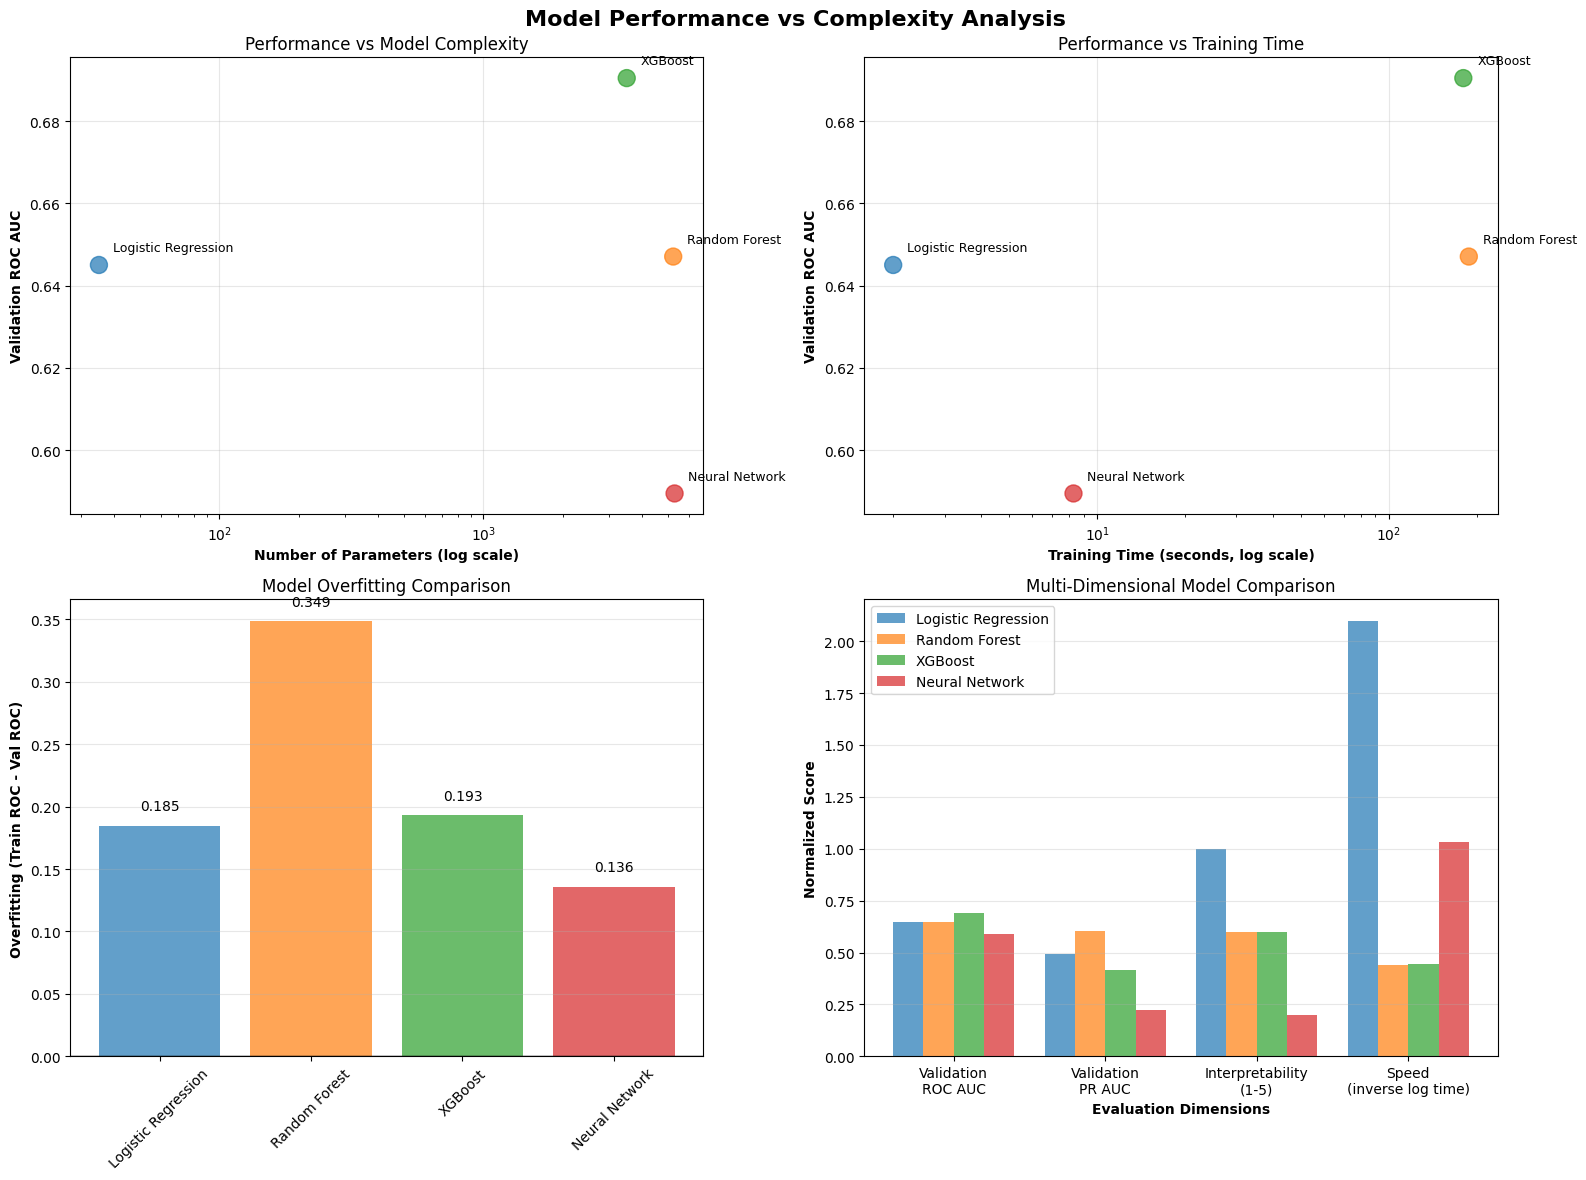

Model Complexity Summary:
Logistic Regression:
  - Parameters: 35
  - Training Time: 2.0s
  - Validation ROC AUC: 0.645
  - Overfitting Score: 0.185
  - Interpretability: 5/5

Random Forest:
  - Parameters: 5,250
  - Training Time: 188.0s
  - Validation ROC AUC: 0.647
  - Overfitting Score: 0.349
  - Interpretability: 3/5

XGBoost:
  - Parameters: 3,500
  - Training Time: 180.0s
  - Validation ROC AUC: 0.690
  - Overfitting Score: 0.193
  - Interpretability: 3/5

Neural Network:
  - Parameters: 5,313
  - Training Time: 8.3s
  - Validation ROC AUC: 0.590
  - Overfitting Score: 0.136
  - Interpretability: 1/5



In [8]:
# Model Performance vs Complexity Analysis
def analyze_performance_complexity():
    """
    Analyzes the trade off between model complexity and performance
    """
    # Model complexity metrics (approximate)
    complexity_data = {
        'Logistic Regression': {
            'parameters': len(selected_features) + 1, # weights + bias
            'training_time': 2.0, # estimated
            'interpretability': 5, # 1-5 scale
            'val_roc_auc': performance_metrics['logistic_regression']['val']['roc_auc'],
            'val_pr_auc': performance_metrics['logistic_regression']['val']['pr_auc'],
            'overfitting': performance_metrics['logistic_regression']['train']['roc_auc'] - performance_metrics['logistic_regression']['val']['roc_auc']
        },
        'Random Forest': {
            'parameters': 150 * (len(selected_features) + 1), # 150 trees
            'training_time': 188.0,
            'interpretability': 3,
            'val_roc_auc': performance_metrics['random_forest']['val']['roc_auc'],
            'val_pr_auc': performance_metrics['random_forest']['val']['pr_auc'],
            'overfitting': performance_metrics['random_forest']['train']['roc_auc'] - performance_metrics['random_forest']['val']['roc_auc']
        },
        'XGBoost': {
            'parameters': 100 * (len(selected_features) + 1), # 100 estimators
            'training_time': 180.0, # estimated from grid search
            'interpretability': 3,
            'val_roc_auc': performance_metrics['xgboost']['val']['roc_auc'],
            'val_pr_auc': performance_metrics['xgboost']['val']['pr_auc'],
            'overfitting': performance_metrics['xgboost']['train']['roc_auc'] - performance_metrics['xgboost']['val']['roc_auc']
        },
        'Neural Network': {
            'parameters': 5313, # from model summary
            'training_time': 8.3,
            'interpretability': 1,
            'val_roc_auc': performance_metrics['neural_network']['val']['roc_auc'],
            'val_pr_auc': performance_metrics['neural_network']['val']['pr_auc'],
            'overfitting': performance_metrics['neural_network']['train']['roc_auc'] - performance_metrics['neural_network']['val']['roc_auc']
        }
    }

    # Creates complexity comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Model Performance vs Complexity Analysis', fontsize=16, fontweight='bold')

    models = list(complexity_data.keys())
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

    # Performance vs Parameters
    ax1 = axes[0, 0]
    parameters = [complexity_data[m]['parameters'] for m in models]
    roc_aucs = [complexity_data[m]['val_roc_auc'] for m in models]
    scatter1 = ax1.scatter(parameters, roc_aucs, c=colors, s=150, alpha=0.7)
    ax1.set_xlabel('Number of Parameters (log scale)', fontweight='bold')
    ax1.set_ylabel('Validation ROC AUC', fontweight='bold')
    ax1.set_title('Performance vs Model Complexity')
    ax1.set_xscale('log')
    ax1.grid(True, alpha=0.3)
    for i, model in enumerate(models):
        ax1.annotate(model, (parameters[i], roc_aucs[i]),
                    xytext=(10, 10), textcoords='offset points', fontsize=9)

    # Training Time vs Performance
    ax2 = axes[0, 1]
    training_times = [complexity_data[m]['training_time'] for m in models]
    scatter2 = ax2.scatter(training_times, roc_aucs, c=colors, s=150, alpha=0.7)
    ax2.set_xlabel('Training Time (seconds, log scale)', fontweight='bold')
    ax2.set_ylabel('Validation ROC AUC', fontweight='bold')
    ax2.set_title('Performance vs Training Time')
    ax2.set_xscale('log')
    ax2.grid(True, alpha=0.3)
    for i, model in enumerate(models):
        ax2.annotate(model, (training_times[i], roc_aucs[i]),
                    xytext=(10, 10), textcoords='offset points', fontsize=9)

    # Overfitting Analysis
    ax3 = axes[1, 0]
    overfitting = [complexity_data[m]['overfitting'] for m in models]
    bars = ax3.bar(models, overfitting, color=colors, alpha=0.7)
    ax3.set_ylabel('Overfitting (Train ROC - Val ROC)', fontweight='bold')
    ax3.set_title('Model Overfitting Comparison')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.axhline(y=0, color='black', linewidth=1)
    for bar, value in zip(bars, overfitting):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontsize=10)

    # Performance Summary
    ax4 = axes[1, 1]
    # Creates comparison
    metrics = ['Validation\nROC AUC', 'Validation\nPR AUC', 'Interpretability\n(1-5)', 'Speed\n(inverse log time)']
    model_scores = []
    for model in models:
        scores = [
            complexity_data[model]['val_roc_auc'],
            complexity_data[model]['val_pr_auc'] * 5, # Scale up PR AUC
            complexity_data[model]['interpretability'] / 5, # Normalize to 0-1
            1 / np.log10(complexity_data[model]['training_time'] + 1) # Speed score
        ]
        model_scores.append(scores)

    x_pos = np.arange(len(metrics))
    width = 0.2
    for i, (model, scores) in enumerate(zip(models, model_scores)):
        ax4.bar(x_pos + i * width, scores, width, label=model, color=colors[i], alpha=0.7)

    ax4.set_xlabel('Evaluation Dimensions', fontweight='bold')
    ax4.set_ylabel('Normalized Score', fontweight='bold')
    ax4.set_title('Multi-Dimensional Model Comparison')
    ax4.set_xticks(x_pos + width * 1.5)
    ax4.set_xticklabels(metrics, rotation=0)
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    # Prints complexity summary
    print("Model Complexity Summary:")
    for model, data in complexity_data.items():
        print(f"{model}:")
        print(f"  - Parameters: {data['parameters']:,}")
        print(f"  - Training Time: {data['training_time']:.1f}s")
        print(f"  - Validation ROC AUC: {data['val_roc_auc']:.3f}")
        print(f"  - Overfitting Score: {data['overfitting']:.3f}")
        print(f"  - Interpretability: {data['interpretability']}/5")
        print()

analyze_performance_complexity()

# Confusion Matrix Analysis

### Overview

The confusion matrix comparison reveals critical performance patterns across four machine learning models evaluated on training, validation, and test datasets. The analysis exposes significant class imbalance issues and model generalization problems that require immediate attention. The confusion matrices reveal fundamental modeling challenges that extend beyond simple hyperparameter tuning, requiring systematic pipeline improvements.

### Model Rankings by Test Performance

1. **Random Forest** - Best specificity (0.955) but poor sensitivity (0.167)
2. **XGBoost** - Moderate specificity (0.732) with limited sensitivity (0.167)  
3. **Neural Network** - Balanced but weak performance (0.500 sensitivity/specificity)
4. **Logistic Regression** - Poorest overall test performance

### Critical Observations

**Severe Class Imbalance Impact**
- Extremely low positive predictive values across all models (0.006-0.037 on test)
- High negative predictive values (0.986-0.991) due to class distribution
- Models struggle to identify injury cases effectively

**Generalization Failures**
- Random Forest shows extreme overfitting (0.624 train PPV vs 0.037 test PPV)
- Consistent performance degradation from training to test across all models
- Validation metrics suggest potential data leakage or preprocessing issues

**Sensitivity vs Specificity Trade offs**
- Most models favor specificity over sensitivity on test data
- Neural Network achieves most balanced performance but at poor overall levels
- Critical for injury prediction where false negatives carry high cost

## Improvement Recommendations
1. **Address Class Imbalance** - Implement SMOTE, class weighting, or threshold optimization
2. **Regularization Enhancement** - Apply stronger regularization to prevent overfitting
3. **Validation Strategy Review** - Investigate validation set construction methodology
4. **Cost-Sensitive Learning** - Adjust models to minimize false negative rates for injury detection

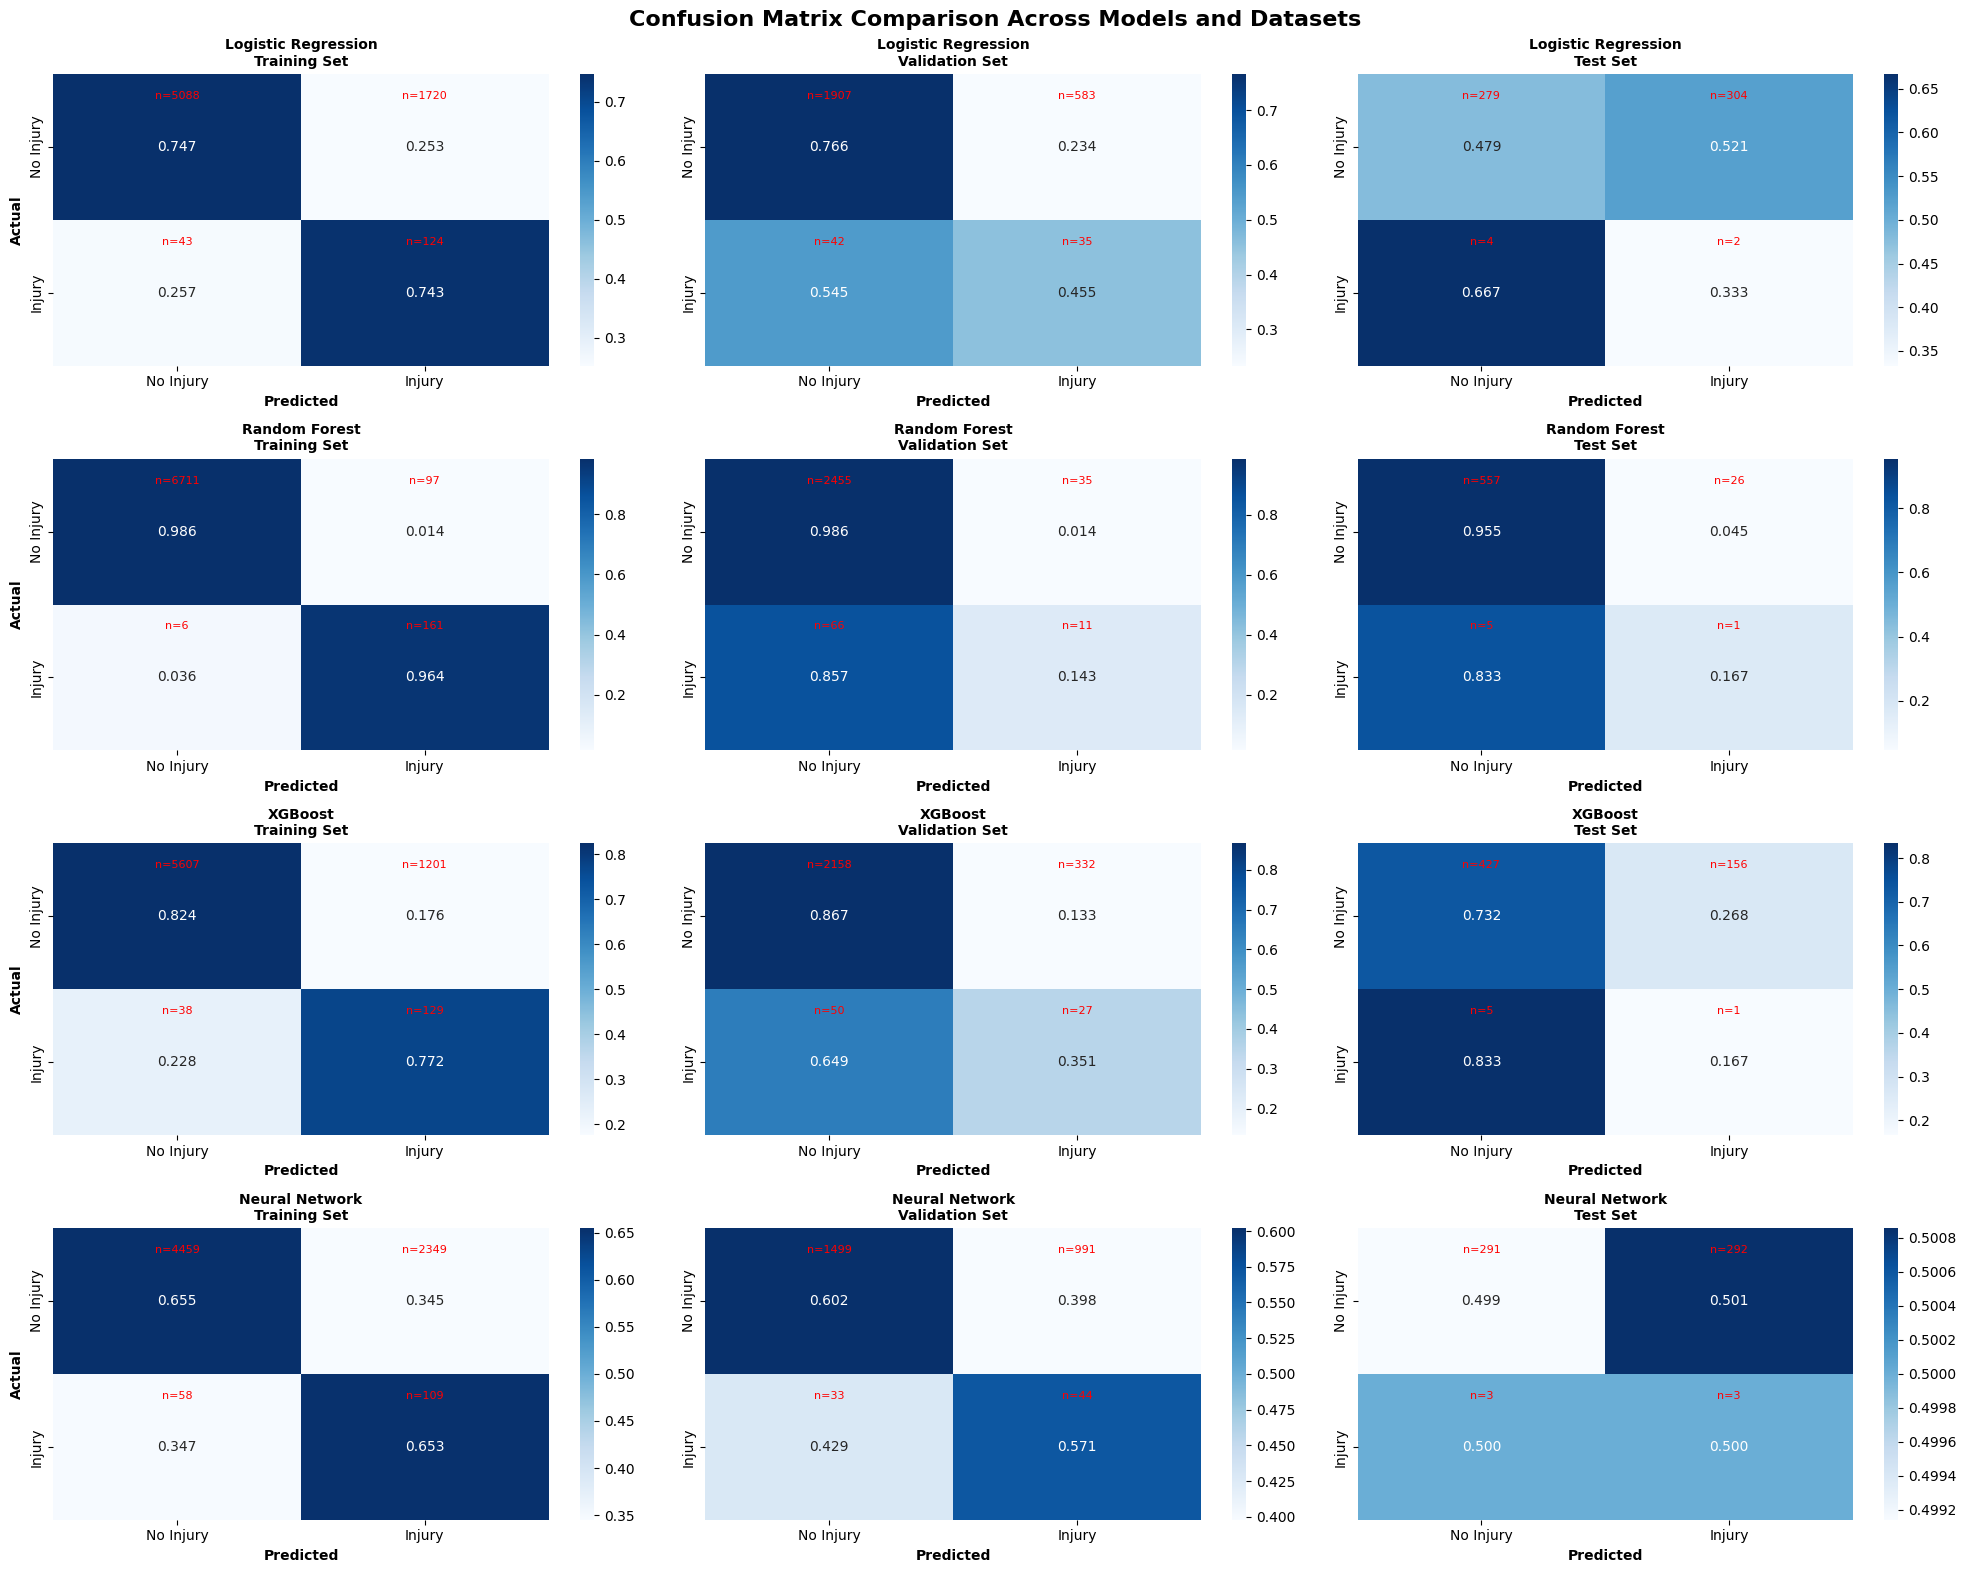

Performance Metrics from Confusion Matrices:

LOGISTIC REGRESSION:
  Training   | Sens: 0.743 | Spec: 0.747 | PPV: 0.067 | NPV: 0.992
  Validation | Sens: 0.455 | Spec: 0.766 | PPV: 0.057 | NPV: 0.978
  Test       | Sens: 0.333 | Spec: 0.479 | PPV: 0.007 | NPV: 0.986

RANDOM FOREST:
  Training   | Sens: 0.964 | Spec: 0.986 | PPV: 0.624 | NPV: 0.999
  Validation | Sens: 0.143 | Spec: 0.986 | PPV: 0.239 | NPV: 0.974
  Test       | Sens: 0.167 | Spec: 0.955 | PPV: 0.037 | NPV: 0.991

XGBOOST:
  Training   | Sens: 0.772 | Spec: 0.824 | PPV: 0.097 | NPV: 0.993
  Validation | Sens: 0.351 | Spec: 0.867 | PPV: 0.075 | NPV: 0.977
  Test       | Sens: 0.167 | Spec: 0.732 | PPV: 0.006 | NPV: 0.988

NEURAL NETWORK:
  Training   | Sens: 0.653 | Spec: 0.655 | PPV: 0.044 | NPV: 0.987
  Validation | Sens: 0.571 | Spec: 0.602 | PPV: 0.043 | NPV: 0.978
  Test       | Sens: 0.500 | Spec: 0.499 | PPV: 0.010 | NPV: 0.990


In [9]:
# Confusion Matrix Comparison and Error Analysis
def create_confusion_matrix_analysis():
    """
    Creates confusion matrix comparison and error analysis
    """
    # Collects confusion matrices from performance_metrics
    cms = {
        'Logistic Regression': {
            'train': performance_metrics['logistic_regression']['train']['confusion_matrix'],
            'val': performance_metrics['logistic_regression']['val']['confusion_matrix'],
            'test': performance_metrics['logistic_regression']['test']['confusion_matrix']
        },
        'Random Forest': {
            'train': performance_metrics['random_forest']['train']['confusion_matrix'],
            'val': performance_metrics['random_forest']['val']['confusion_matrix'],
            'test': performance_metrics['random_forest']['test']['confusion_matrix']
        },
        'XGBoost': {
            'train': performance_metrics['xgboost']['train']['confusion_matrix'],
            'val': performance_metrics['xgboost']['val']['confusion_matrix'],
            'test': performance_metrics['xgboost']['test']['confusion_matrix']
        },
        'Neural Network': {
            'train': performance_metrics['neural_network']['train']['confusion_matrix'],
            'val': performance_metrics['neural_network']['val']['confusion_matrix'],
            'test': performance_metrics['neural_network']['test']['confusion_matrix']
        }
    }

    # Creates subplots for confusion matrices
    fig = plt.figure(figsize=(20, 16))
    model_names = list(cms.keys())
    datasets = ['train', 'val', 'test']
    dataset_titles = ['Training', 'Validation', 'Test']

    for i, model in enumerate(model_names):
        for j, (dataset, title) in enumerate(zip(datasets, dataset_titles)):
            ax = plt.subplot(4, 3, i * 3 + j + 1)
            cm = cms[model][dataset]

            # Creates normalized confusion matrix for better visualization
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

            # Plots confusion matrix
            sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
                       xticklabels=['No Injury', 'Injury'],
                       yticklabels=['No Injury', 'Injury'],
                       ax=ax, cbar=True)
            
            ax.set_title(f'{model}\n{title} Set', fontweight='bold', fontsize=10)
            ax.set_xlabel('Predicted', fontweight='bold')
            if j == 0:  # Only add ylabel to leftmost plots
                ax.set_ylabel('Actual', fontweight='bold')

            # Adds raw counts as text
            for row in range(2):
                for col in range(2):
                    ax.text(col + 0.5, row + 0.15, f'n={cm[row, col]}',
                           ha='center', va='center', fontsize=8, color='red')

    plt.suptitle('Confusion Matrix Comparison Across Models and Datasets',
                fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    plt.show()

    # Calculates and display key metrics from confusion matrices
    print("Performance Metrics from Confusion Matrices:")
    for model in model_names:
        print(f"\n{model.upper()}:")
        for dataset, title in zip(datasets, dataset_titles):
            cm = cms[model][dataset]
            tn, fp, fn, tp = cm.ravel()

            # Calculates metrics
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value
            npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value

            print(f"  {title:10} | Sens: {sensitivity:.3f} | Spec: {specificity:.3f} | PPV: {ppv:.3f} | NPV: {npv:.3f}")

create_confusion_matrix_analysis()

# Top K Risk Analysis

### Overview

The top K risk analysis evaluates how effectively each model identifies high risk individuals by examining performance at different percentile thresholds. This analysis is crucial for resource allocation and intervention prioritization in injury prevention programs. The analysis reveals fundamental limitations in risk stratification capabilities across all models, suggesting need for enhanced feature engineering or alternative modeling approaches.

### Model Performance Rankings (By F1-Score)

1. **Random Forest** - Highest F1-score (0.187) at 2% threshold with superior precision
2. **XGBoost** - Strong F1-score (0.144) at 17% threshold with best capture rate
3. **Logistic Regression** - Moderate F1-score (0.126) at 10% threshold
4. **Neural Network** - Weakest F1-score (0.095) at 6% threshold

### Key Performance Insights

**Precision vs Coverage Trade offs**
- Random Forest achieves highest precision (0.235) but covers only 15.6% of injuries
- XGBoost captures nearly half of all injuries (48.1%) but with lower precision (0.085)
- All models show declining precision as K increases, typical of imbalanced datasets

**Risk Score Discrimination**
- Models demonstrate poor separation between injury and no-injury cases
- Risk distributions heavily overlap, indicating limited predictive power
- Most predictions cluster in low risk ranges regardless of actual outcomes

**Optimal Operating Points**
- Random Forest optimal at very selective 2% threshold suggests high confidence needed
- XGBoost optimal at broader 17% threshold indicates better overall ranking ability
- Large variation in optimal K values reflects different model calibration characteristics

### Improvement Recommendations

- Random Forest best for limited intervention capacity requiring high precision
- XGBoost preferred when broader screening coverage is acceptable
- Logistic Regression offers middle ground approach at 10% threshold
- High-stakes interventions favor Random Forest precision-focused approach
- Population screening programs benefit from XGBoost coverage optimization
- Current models insufficient for confident individual risk assessment

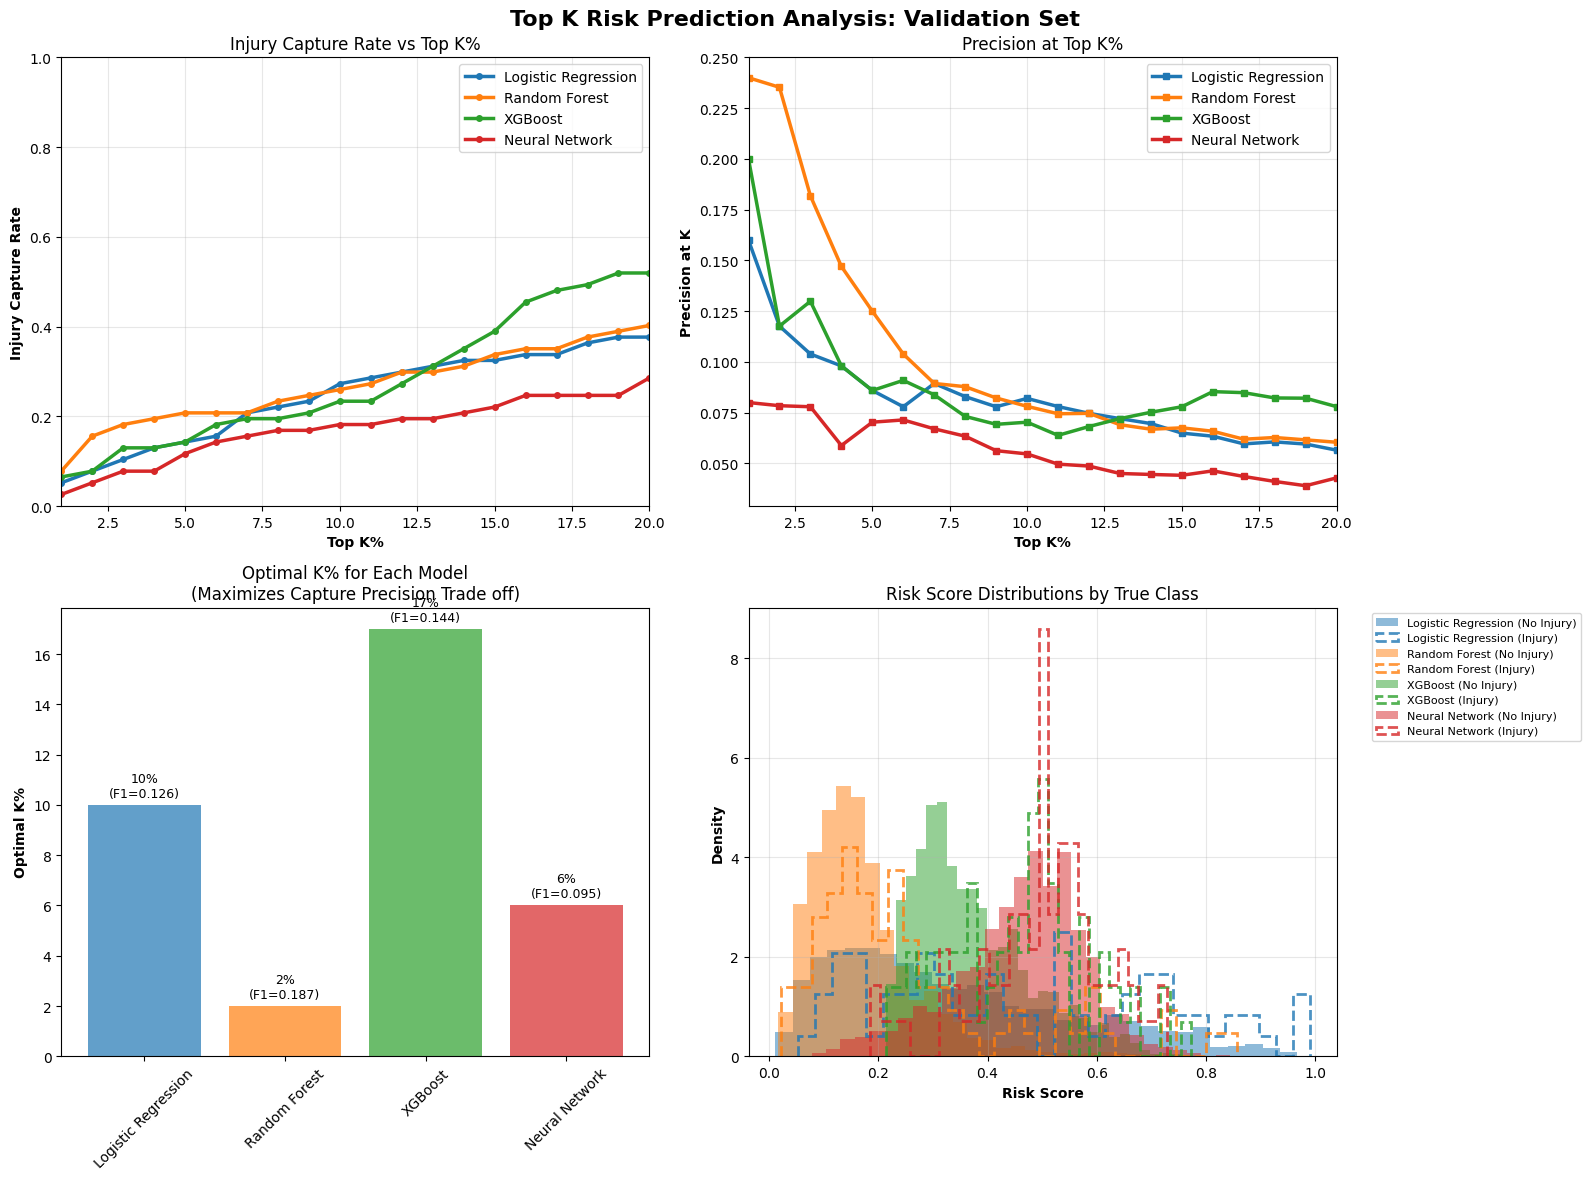

Optimal Top K Analysis Summary:
Logistic Regression:
- Optimal K: 10%
- Capture Rate: 0.273
- Precision: 0.082
- F1-Score: 0.126

Random Forest:
- Optimal K: 2%
- Capture Rate: 0.156
- Precision: 0.235
- F1-Score: 0.187

XGBoost:
- Optimal K: 17%
- Capture Rate: 0.481
- Precision: 0.085
- F1-Score: 0.144

Neural Network:
- Optimal K: 6%
- Capture Rate: 0.143
- Precision: 0.071
- F1-Score: 0.095



In [10]:
# Top K Risk Analysis Comparison 
def analyze_top_k_risk_all_models():
    """
    Compares top K risk prediction performance across all models
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Top K Risk Prediction Analysis: Validation Set', fontsize=16, fontweight='bold')
    
    # Accesses probability predictions from the predictions dictionary
    models_data = {
        'Logistic Regression': predictions['logistic_regression']['val_prob'],
        'Random Forest': predictions['random_forest']['val_prob'],
        'XGBoost': predictions['xgboost']['val_prob'],
        'Neural Network': predictions['neural_network']['val_prob']
    }
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    k_values = np.arange(1, 21)  # Top 1% to 20%
    
    # Calculates capture rates for each K
    capture_rates = {}
    precisions = {}
    
    for model_name, probs in models_data.items():
        # Uses y_val consistently for all models
        y_true = y_val.values
        
        sorted_indices = np.argsort(probs)[::-1]
        sorted_true = y_true[sorted_indices]
        total_positives = y_true.sum()
        n_samples = len(y_true)
        
        model_capture_rates = []
        model_precisions = []
        
        for k in k_values:
            top_k_size = int(n_samples * k / 100)
            if top_k_size > 0:
                top_k_true = sorted_true[:top_k_size]
                captured = top_k_true.sum()
                capture_rate = captured / total_positives if total_positives > 0 else 0
                precision_at_k = captured / top_k_size
                model_capture_rates.append(capture_rate)
                model_precisions.append(precision_at_k)
            else:
                model_capture_rates.append(0)
                model_precisions.append(0)
        
        capture_rates[model_name] = model_capture_rates
        precisions[model_name] = model_precisions
    
    # Plots capture rates
    ax1 = axes[0, 0]
    for i, (model_name, rates) in enumerate(capture_rates.items()):
        ax1.plot(k_values, rates, color=colors[i], linewidth=2.5, marker='o', 
                markersize=4, label=model_name)
    
    ax1.set_xlabel('Top K%', fontweight='bold')
    ax1.set_ylabel('Injury Capture Rate', fontweight='bold')
    ax1.set_title('Injury Capture Rate vs Top K%')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim([1, 20])
    ax1.set_ylim([0, 1])
    
    # Plots precisions
    ax2 = axes[0, 1]
    for i, (model_name, precs) in enumerate(precisions.items()):
        ax2.plot(k_values, precs, color=colors[i], linewidth=2.5, marker='s', 
                markersize=4, label=model_name)
    
    ax2.set_xlabel('Top K%', fontweight='bold')
    ax2.set_ylabel('Precision at K', fontweight='bold')
    ax2.set_title('Precision at Top K%')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim([1, 20])
    
    # Best K analysis
    ax3 = axes[1, 0]
    
    # Finds optimal K for each model (maximizes F1 like score)
    optimal_k = {}
    optimal_scores = {}
    
    for model_name in models_data.keys():
        f1_scores = []
        for i, k in enumerate(k_values):
            capture = capture_rates[model_name][i]
            precision = precisions[model_name][i]
            if capture + precision > 0:
                f1 = 2 * capture * precision / (capture + precision)
            else:
                f1 = 0
            f1_scores.append(f1)
        
        best_idx = np.argmax(f1_scores)
        optimal_k[model_name] = k_values[best_idx]
        optimal_scores[model_name] = f1_scores[best_idx]
    
    models_list = list(optimal_k.keys())
    k_values_opt = list(optimal_k.values())
    scores_opt = list(optimal_scores.values())
    
    bars = ax3.bar(models_list, k_values_opt, color=colors, alpha=0.7)
    ax3.set_ylabel('Optimal K%', fontweight='bold')
    ax3.set_title('Optimal K% for Each Model\n(Maximizes Capture Precision Trade off)')
    ax3.tick_params(axis='x', rotation=45)
    
    for bar, k_val, score in zip(bars, k_values_opt, scores_opt):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, 
                f'{k_val}%\n(F1={score:.3f})', ha='center', va='bottom', fontsize=9)
    
    # Risk distribution analysis
    ax4 = axes[1, 1]
    
    # Plots risk score distributions
    for i, (model_name, probs) in enumerate(models_data.items()):
        y_true = y_val.values
        
        # Separate probabilities by true class
        injury_probs = probs[y_true == 1]
        no_injury_probs = probs[y_true == 0]
        
        # Plot histograms
        ax4.hist(no_injury_probs, bins=30, alpha=0.5, color=colors[i], 
                label=f'{model_name} (No Injury)', density=True)
        ax4.hist(injury_probs, bins=30, alpha=0.8, color=colors[i], 
                label=f'{model_name} (Injury)', density=True, linestyle='--', 
                histtype='step', linewidth=2)
    
    ax4.set_xlabel('Risk Score', fontweight='bold')
    ax4.set_ylabel('Density', fontweight='bold')
    ax4.set_title('Risk Score Distributions by True Class')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Optimal K summary
    print("Optimal Top K Analysis Summary:")
    for model_name in models_data.keys():
        k_opt = optimal_k[model_name]
        capture_at_opt = capture_rates[model_name][k_opt - 1]
        precision_at_opt = precisions[model_name][k_opt - 1]
        print(f"{model_name}:")
        print(f"- Optimal K: {k_opt}%")
        print(f"- Capture Rate: {capture_at_opt:.3f}")
        print(f"- Precision: {precision_at_opt:.3f}")
        print(f"- F1-Score: {optimal_scores[model_name]:.3f}")
        print()

analyze_top_k_risk_all_models()